In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]

# Parametros directos
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R # Diametro de la tubería [m]
Delta_T = 50 # diferencia de temperaturas [K]

# Definicion de parametros indirectos
def parametros(D, L, Delta_T):
    h = 1.42 * (Delta_T/L)**(1/4) # coeficiente de transmision de calor por convección (recopilatorio)
    phi = 1/ (beta * Delta_T)
    Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * Delta_T /  h**2 # Numero de Richardson
    Ra = rho_0**2 * g * beta * Cp * D**2 * Delta_T / (16 * nu * h) # Numero de Rayleigh
    LAMBDA = L/D # Relación de aspecto
    delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * Delta_T)
    return h, phi, Ri, Ra, LAMBDA, delta

def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new
        v = v_new
    return v  # Returns the last approximation if it doesn't converge

# Calculo y representación
def calculo_rep(Ra, Ri, delta, v_e, LAMBDA):
    # Definición de variables y condiciones iniciales
    M = 256 # Número de puntos en la dirección vertical
    N = 512 # Número de puntos en la dirección temporal
    eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
    tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
    deta = (eta[-1] - eta[0])/M
    dtau = (tau[-1] - tau[0])/N 
    v = np.zeros(N)  # Velocidad adimensional
    theta_star = np.zeros((M, N))  # Temperatura adimensional

    # Condiciones iniciales
    v[0] = 0.0  # Velocidad inicial cero

    # Simulación numérica
    for t in range(1, N-1):


        # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
        v[t] = v[t-1] + deta * (- Ra**-1 * v[t-1] + theta_star[0, t-1]/v_e)

        # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
        for x in range(M-1):
            
            dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
            d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
            theta_star[x, t] = theta_star[x, t-1] - dtau * (2 * Ri**-1 * v_e * v[t] * dtheta_deta
                                                - delta * d2theta_deta2
                                                + 2 * Ri**-1 * LAMBDA * (theta_star[x, t-1] - 1))
    return v, theta_star, eta, tau

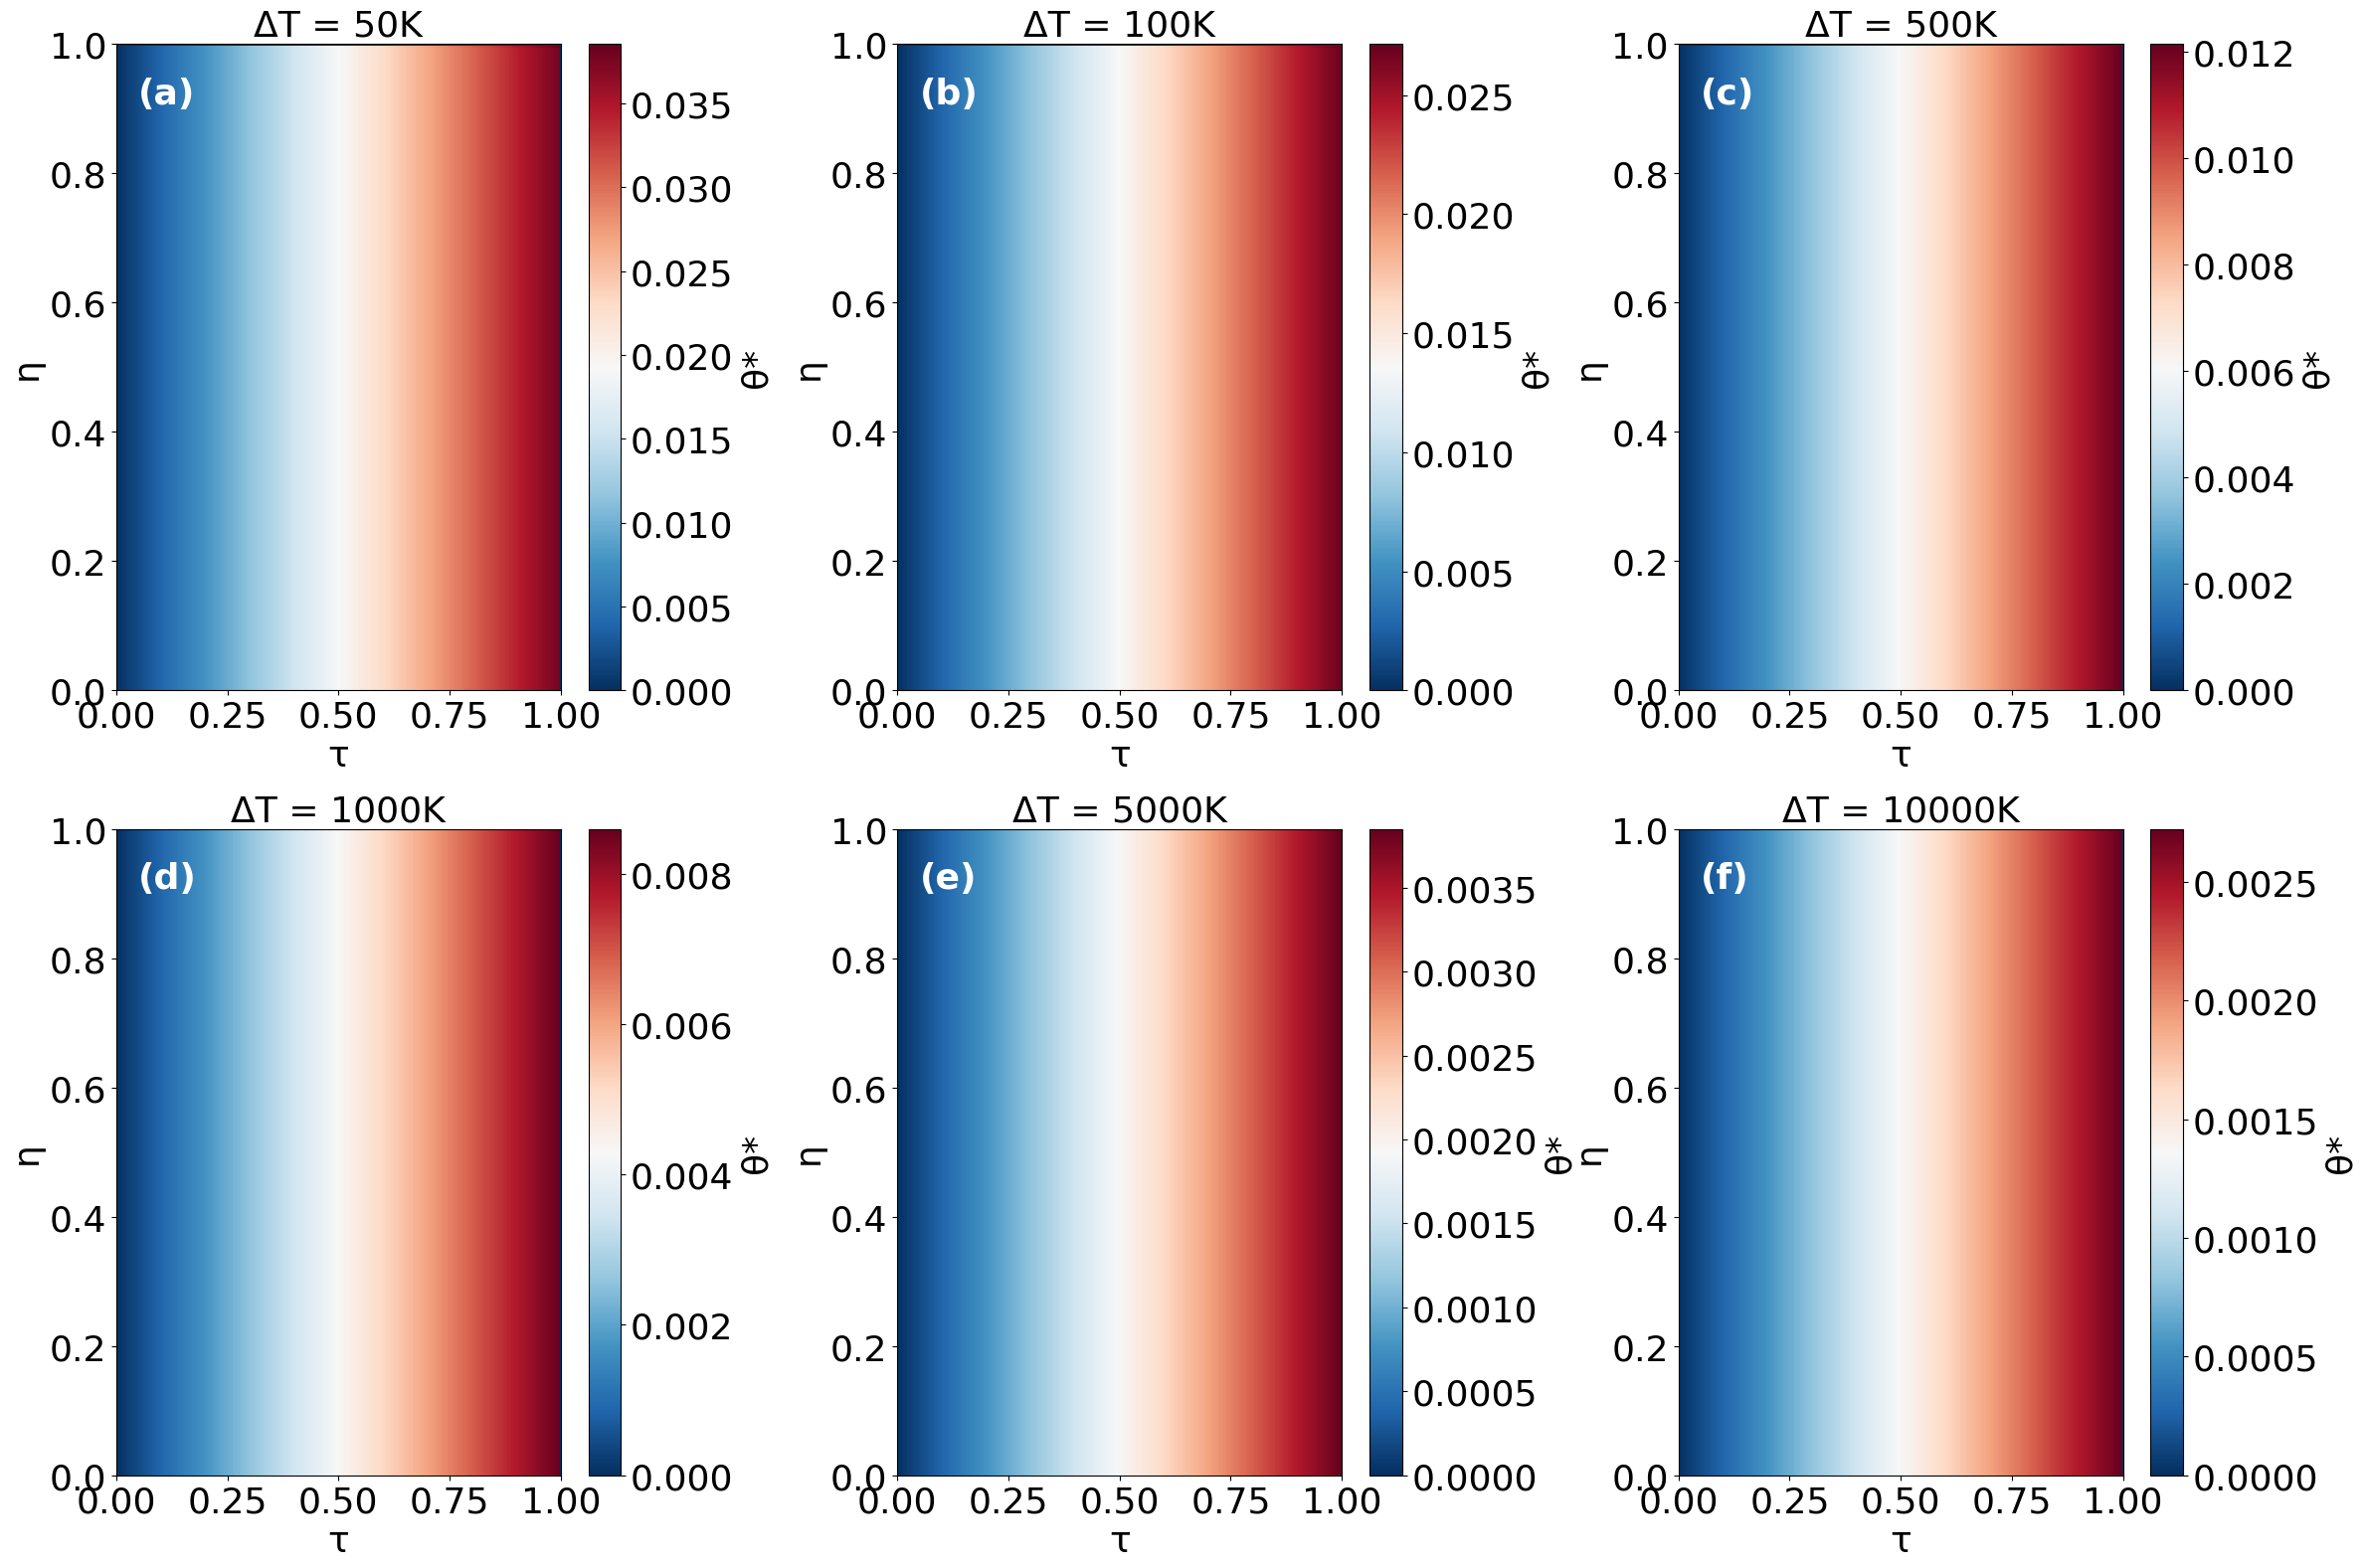

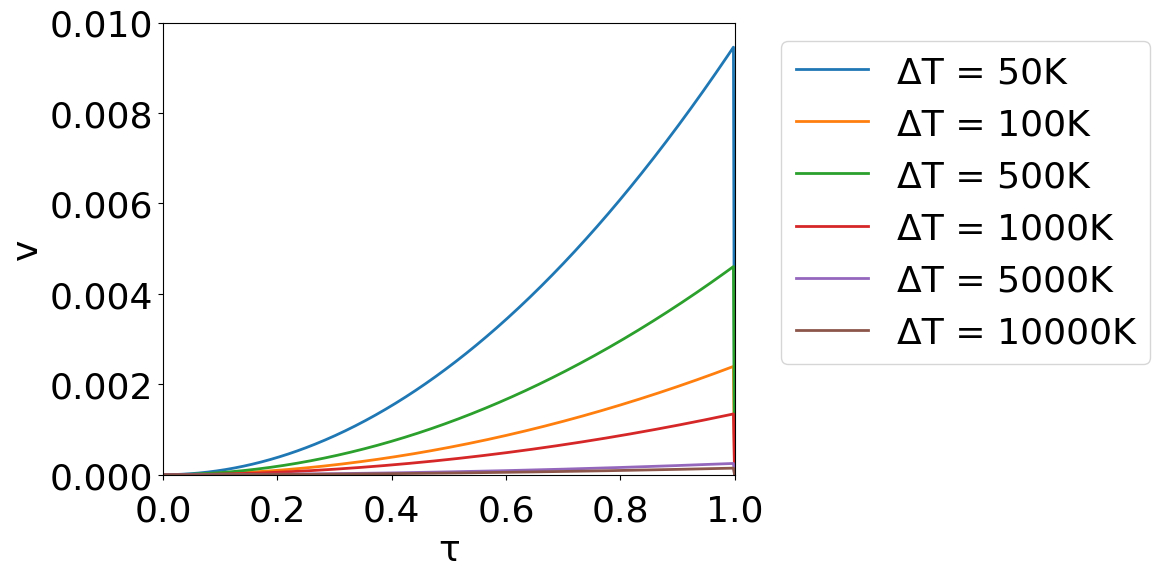

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Lista de diferencias de temperatura
delta_T_list = [50, 100, 500, 1000, 5000, 10000]

# Crear la figura con un tamaño específico
fig, axs = plt.subplots(2, 3, figsize=(24, 16))

# Aplanar la matriz de subplots para facilitar la iteración
axs = axs.flatten()

# Graficar y recopilar datos
for i, delta_T in enumerate(delta_T_list):
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, eta, tau = calculo_rep(Ra, Ri, delta, v_e, LAMBDA)  
    
    # Crear el mapa de calor
    im = axs[i].pcolormesh(tau, eta, theta_star, cmap='RdBu_r', shading='auto')
    
    # Configurar los ejes y etiquetas
    axs[i].set_xlabel('τ', fontsize=26)
    axs[i].set_ylabel('η', fontsize=26)
    axs[i].set_title(f'ΔT = {delta_T:.0f}K', fontsize=26)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].tick_params(axis='both', which='major', labelsize=26)
    
    # Añadir barra de color
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.set_label('θ*', fontsize=26)
    cbar.ax.tick_params(labelsize=26)
    
    # Añadir etiqueta (a, b, c, d, e, f) en la esquina superior izquierda
    axs[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs[i].transAxes, 
                fontsize=26, fontweight='bold', va='top', color='white')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Gráfica de velocidad
fig, ax = plt.subplots(figsize=(12, 6))

for delta_T in delta_T_list:
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, eta, tau = calculo_rep(Ra, Ri, delta, v_e, LAMBDA)  
    ax.plot(tau, v, linewidth=2, label=f'ΔT = {delta_T:.0f}K')

ax.set_xlabel('τ', fontsize=26)
ax.set_ylabel('v', fontsize=26)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.01)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='x', which='major', pad=10)

ax.legend(fontsize=26, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## CON PRESIONES

In [33]:
# Calculo y representación
def calculo_temp_presiones(Ra, Ri, delta, v_e, LAMBDA):
    # Definición de variables y condiciones iniciales
    M = 256 # Número de puntos en la dirección vertical
    N = 512 # Número de puntos en la dirección temporal
    eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
    tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
    deta = (eta[-1] - eta[0])/M
    dtau = (tau[-1] - tau[0])/N 
    v = np.zeros(N)  # Velocidad adimensional
    theta_star = np.zeros((M, N))  # Temperatura adimensional
    xi = np.zeros((M, N)) # Presiones adimensionales

    # Condiciones iniciales
    v[0] = 0.0  # Velocidad inicial cero

    # Simulación numérica
    for t in range(1, N-1):


        # Calculo de la velocidad en el instante i+1 a partir de la presión en eta = 0 del instante anterior:
        v[t] = np.sqrt(Ri * phi * xi[0, t-1])/v_e

        # Calculo de las distribuciones de temperatura y presion en el espacio para el instante i+1:
        for x in range(M-1):
            
            dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
            d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
            theta_star[x, t] = theta_star[x, t-1] - dtau * (2 * Ri**-1 * v_e * v[t] * dtheta_deta
                                                - delta * d2theta_deta2
                                                + 2 * Ri**-1 * LAMBDA * (theta_star[x, t-1] - 1))
    
        # Cálculo de la presión
        for x in range(M-1, 0, -1):
            if (x == M-1) or (x == M-2):
                xi[x, t] = 0
            else:
                dtheta_deta = (theta_star[x+1, t-1] - theta_star[x, t-1]) / deta
                xi[x, t] = 2 * xi[x+1, t] - xi[x+2, t] + 0.5 * deta * dtheta_deta

        # Redefinición de v
        v[t] = v[t-1] + deta * (- phi / v_e * (xi[1, t-1] - xi[0, t-1]) / deta - Ra**-1 * v[t-1] + theta_star[0, t-1]/v_e)


    return v, theta_star, xi, eta, tau

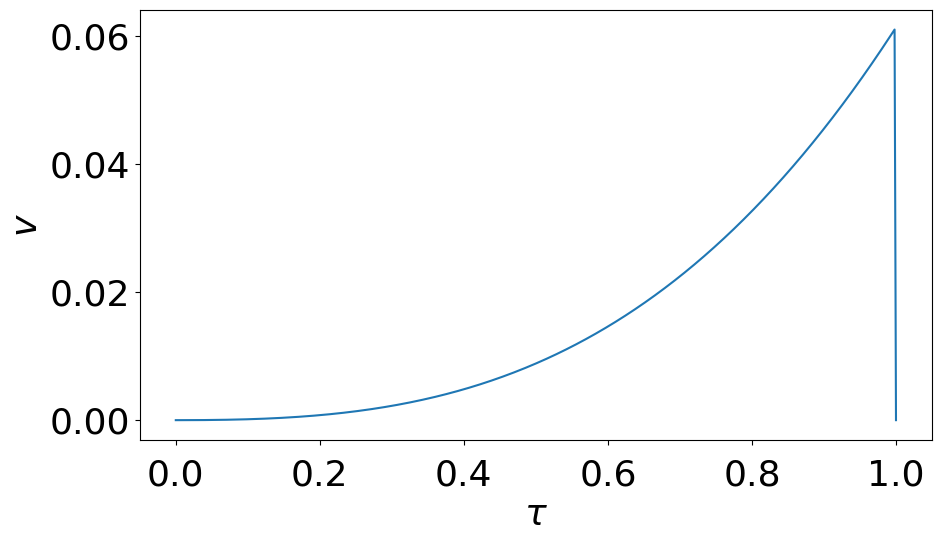

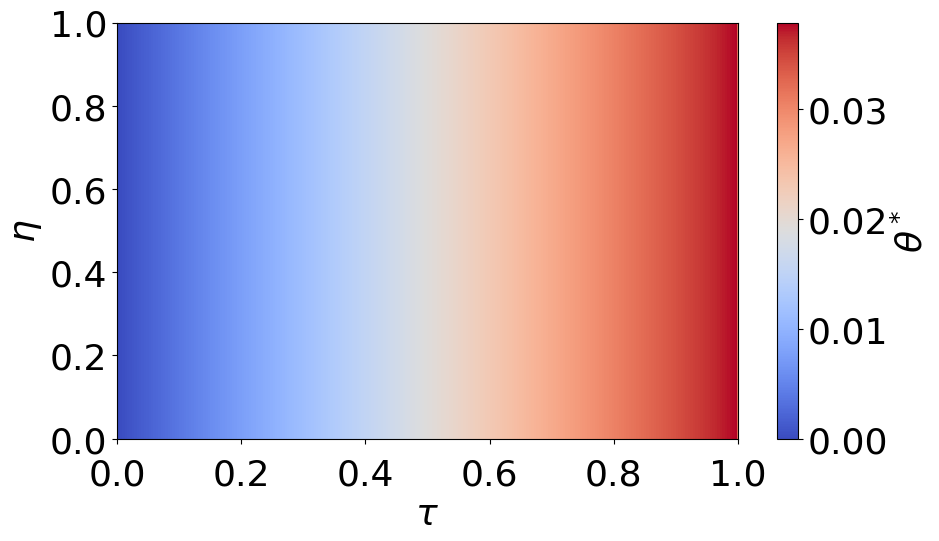

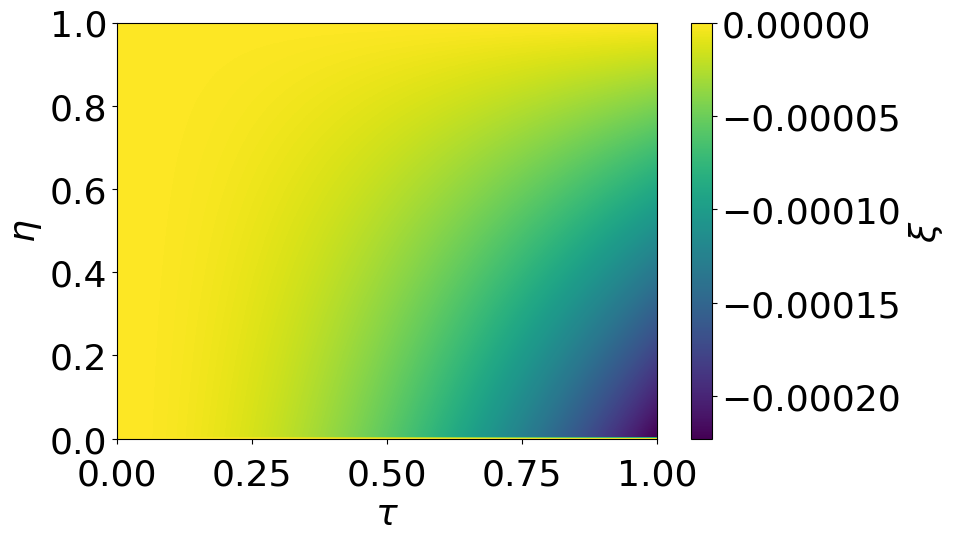

<Figure size 640x480 with 0 Axes>

Numero de Richardson: 2.58e+02
Numero de Rayleigh: 2.23e+06
phi: 5.4496
Lambda: 5.00
v_e: 4.00
Velocidad final: 0.0000
Temperatura máxima: 0.0378
Temperatura mínima: 0.0000
Presión máxima: 0.0000
Presión mínima: -0.0002


In [50]:


# Primero, ejecutamos la función de cálculo
h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, Delta_T)
v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
v, theta_star, xi, eta, tau = calculo_temp_presiones(Ra, Ri, delta, v_e, LAMBDA)

# Configuración general de los gráficos
plt.rcParams.update({'font.size': 26})

# Gráfico de v
plt.figure(figsize=(10, 6))
plt.plot(tau, v)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$v$')
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)
#plt.title('Evolución temporal de la velocidad adimensional')
plt.tight_layout()
plt.show()

# Para theta_star
plt.figure(figsize=(10, 6))
im = plt.imshow(theta_star, aspect='auto', extent=[tau[0], tau[-1], eta[0], eta[-1]], cmap='coolwarm', origin='lower')
plt.colorbar(im, label=r'$\theta^*$')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\eta$')
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)
#plt.title('Distribución de temperatura adimensional')
plt.tight_layout()
plt.show()

# Para xi
plt.figure(figsize=(10, 6))
im = plt.imshow(xi, aspect='auto', extent=[tau[0], tau[-1], eta[0], eta[-1]], cmap='viridis', origin='lower')
plt.colorbar(im, label=r'$\xi$')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\eta$')
plt.tick_params(axis='both', which='major', labelsize=26)
plt.tick_params(axis='x', which='major', pad=10)
#plt.title('Distribución de presión adimensional')
plt.tight_layout()
plt.show()



plt.tight_layout()
plt.show()

# Imprimir valores característicos
print(f'Numero de Richardson: {Ri:.2e}')
print(f'Numero de Rayleigh: {Ra:.2e}')
print(f'phi: {phi:.4f}')
print(f'Lambda: {LAMBDA:.2f}')
print(f'v_e: {v_e:.2f}')
print(f'Velocidad final: {v[-1]:.4f}')
print(f'Temperatura máxima: {np.max(theta_star):.4f}')
print(f'Temperatura mínima: {np.min(theta_star):.4f}')
print(f'Presión máxima: {np.max(xi):.4f}')
print(f'Presión mínima: {np.min(xi):.4f}')


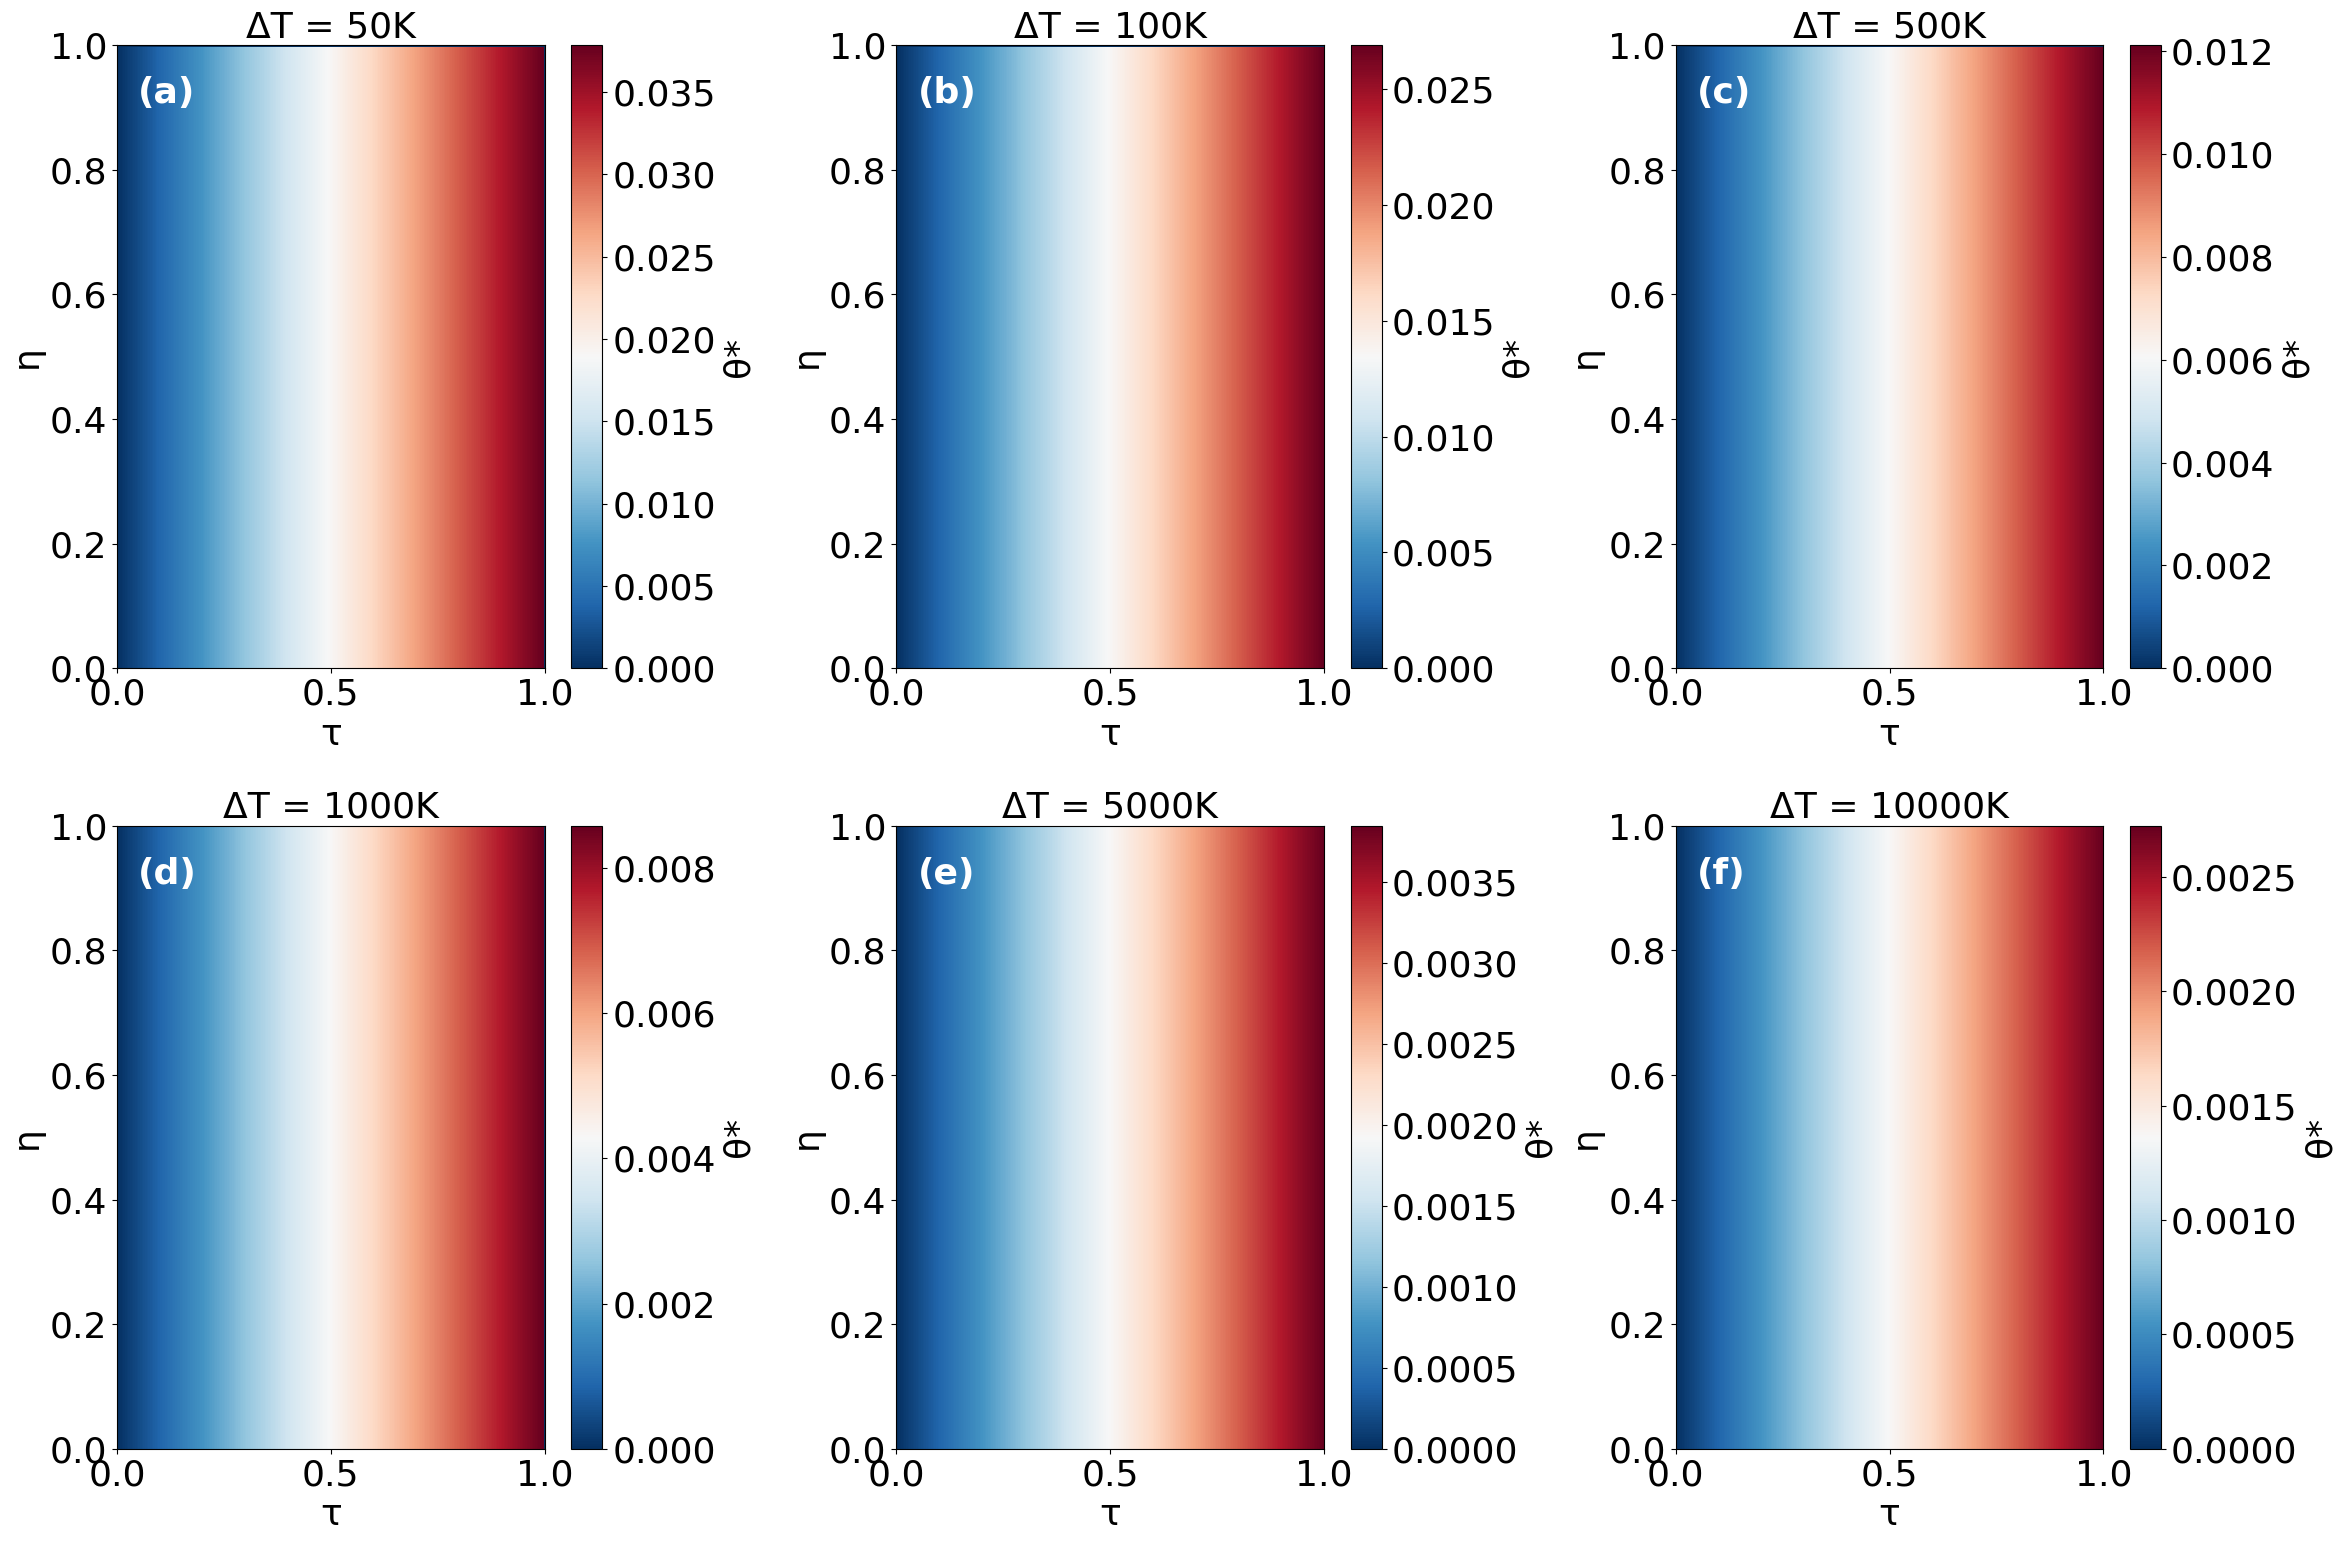

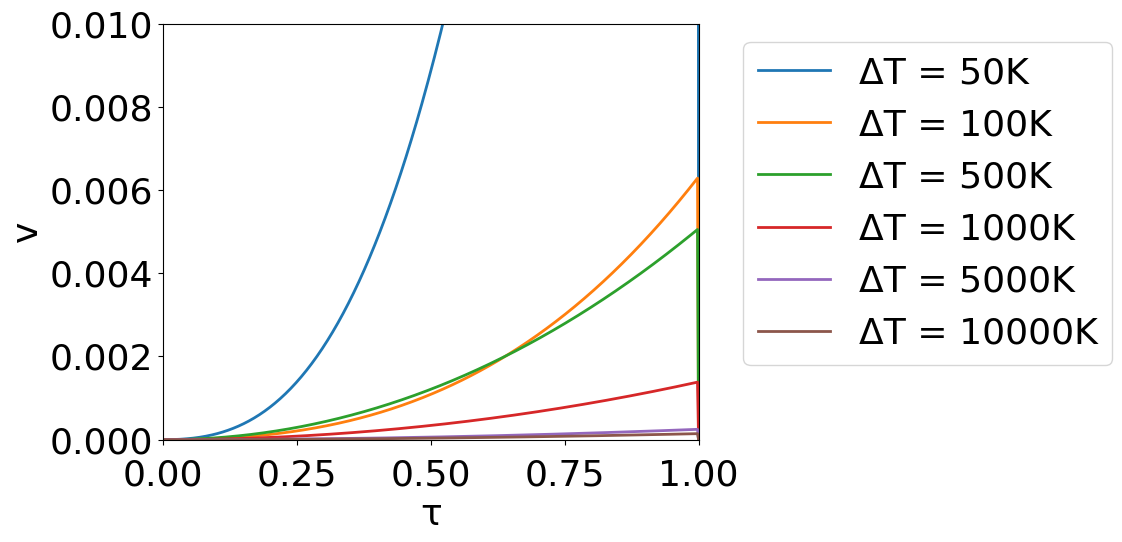

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Lista de diferencias de temperatura
delta_T_list = [50, 100, 500, 1000, 5000, 10000]

# Crear la figura con un tamaño específico
fig, axs = plt.subplots(2, 3, figsize=(24, 16))

# Aplanar la matriz de subplots para facilitar la iteración
axs = axs.flatten()

# Graficar y recopilar datos
for i, delta_T in enumerate(delta_T_list):
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, xi, eta, tau = calculo_temp_presiones(Ra, Ri, delta, v_e, LAMBDA)  
    
    # Crear el mapa de calor
    im = axs[i].pcolormesh(tau, eta, theta_star, cmap='RdBu_r', shading='auto')
    
    # Configurar los ejes y etiquetas
    axs[i].set_xlabel('τ', fontsize=26)
    axs[i].set_ylabel('η', fontsize=26)
    axs[i].set_title(f'ΔT = {delta_T:.0f}K', fontsize=26)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].tick_params(axis='both', which='major', labelsize=26)
    
    # Añadir barra de color
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.set_label('θ*', fontsize=26)
    cbar.ax.tick_params(labelsize=26)
    
    # Añadir etiqueta (a, b, c, d, e, f) en la esquina superior izquierda
    axs[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs[i].transAxes, 
                fontsize=26, fontweight='bold', va='top', color='white')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Gráfica de velocidad
fig, ax = plt.subplots(figsize=(12, 6))

for delta_T in delta_T_list:
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, xi, eta, tau = calculo_temp_presiones(Ra, Ri, delta, v_e, LAMBDA)  
    ax.plot(tau, v, linewidth=2, label=f'ΔT = {delta_T:.0f}K')

ax.set_xlabel('τ', fontsize=26)
ax.set_ylabel('v', fontsize=26)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.01)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='x', which='major', pad=10)

ax.legend(fontsize=26, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




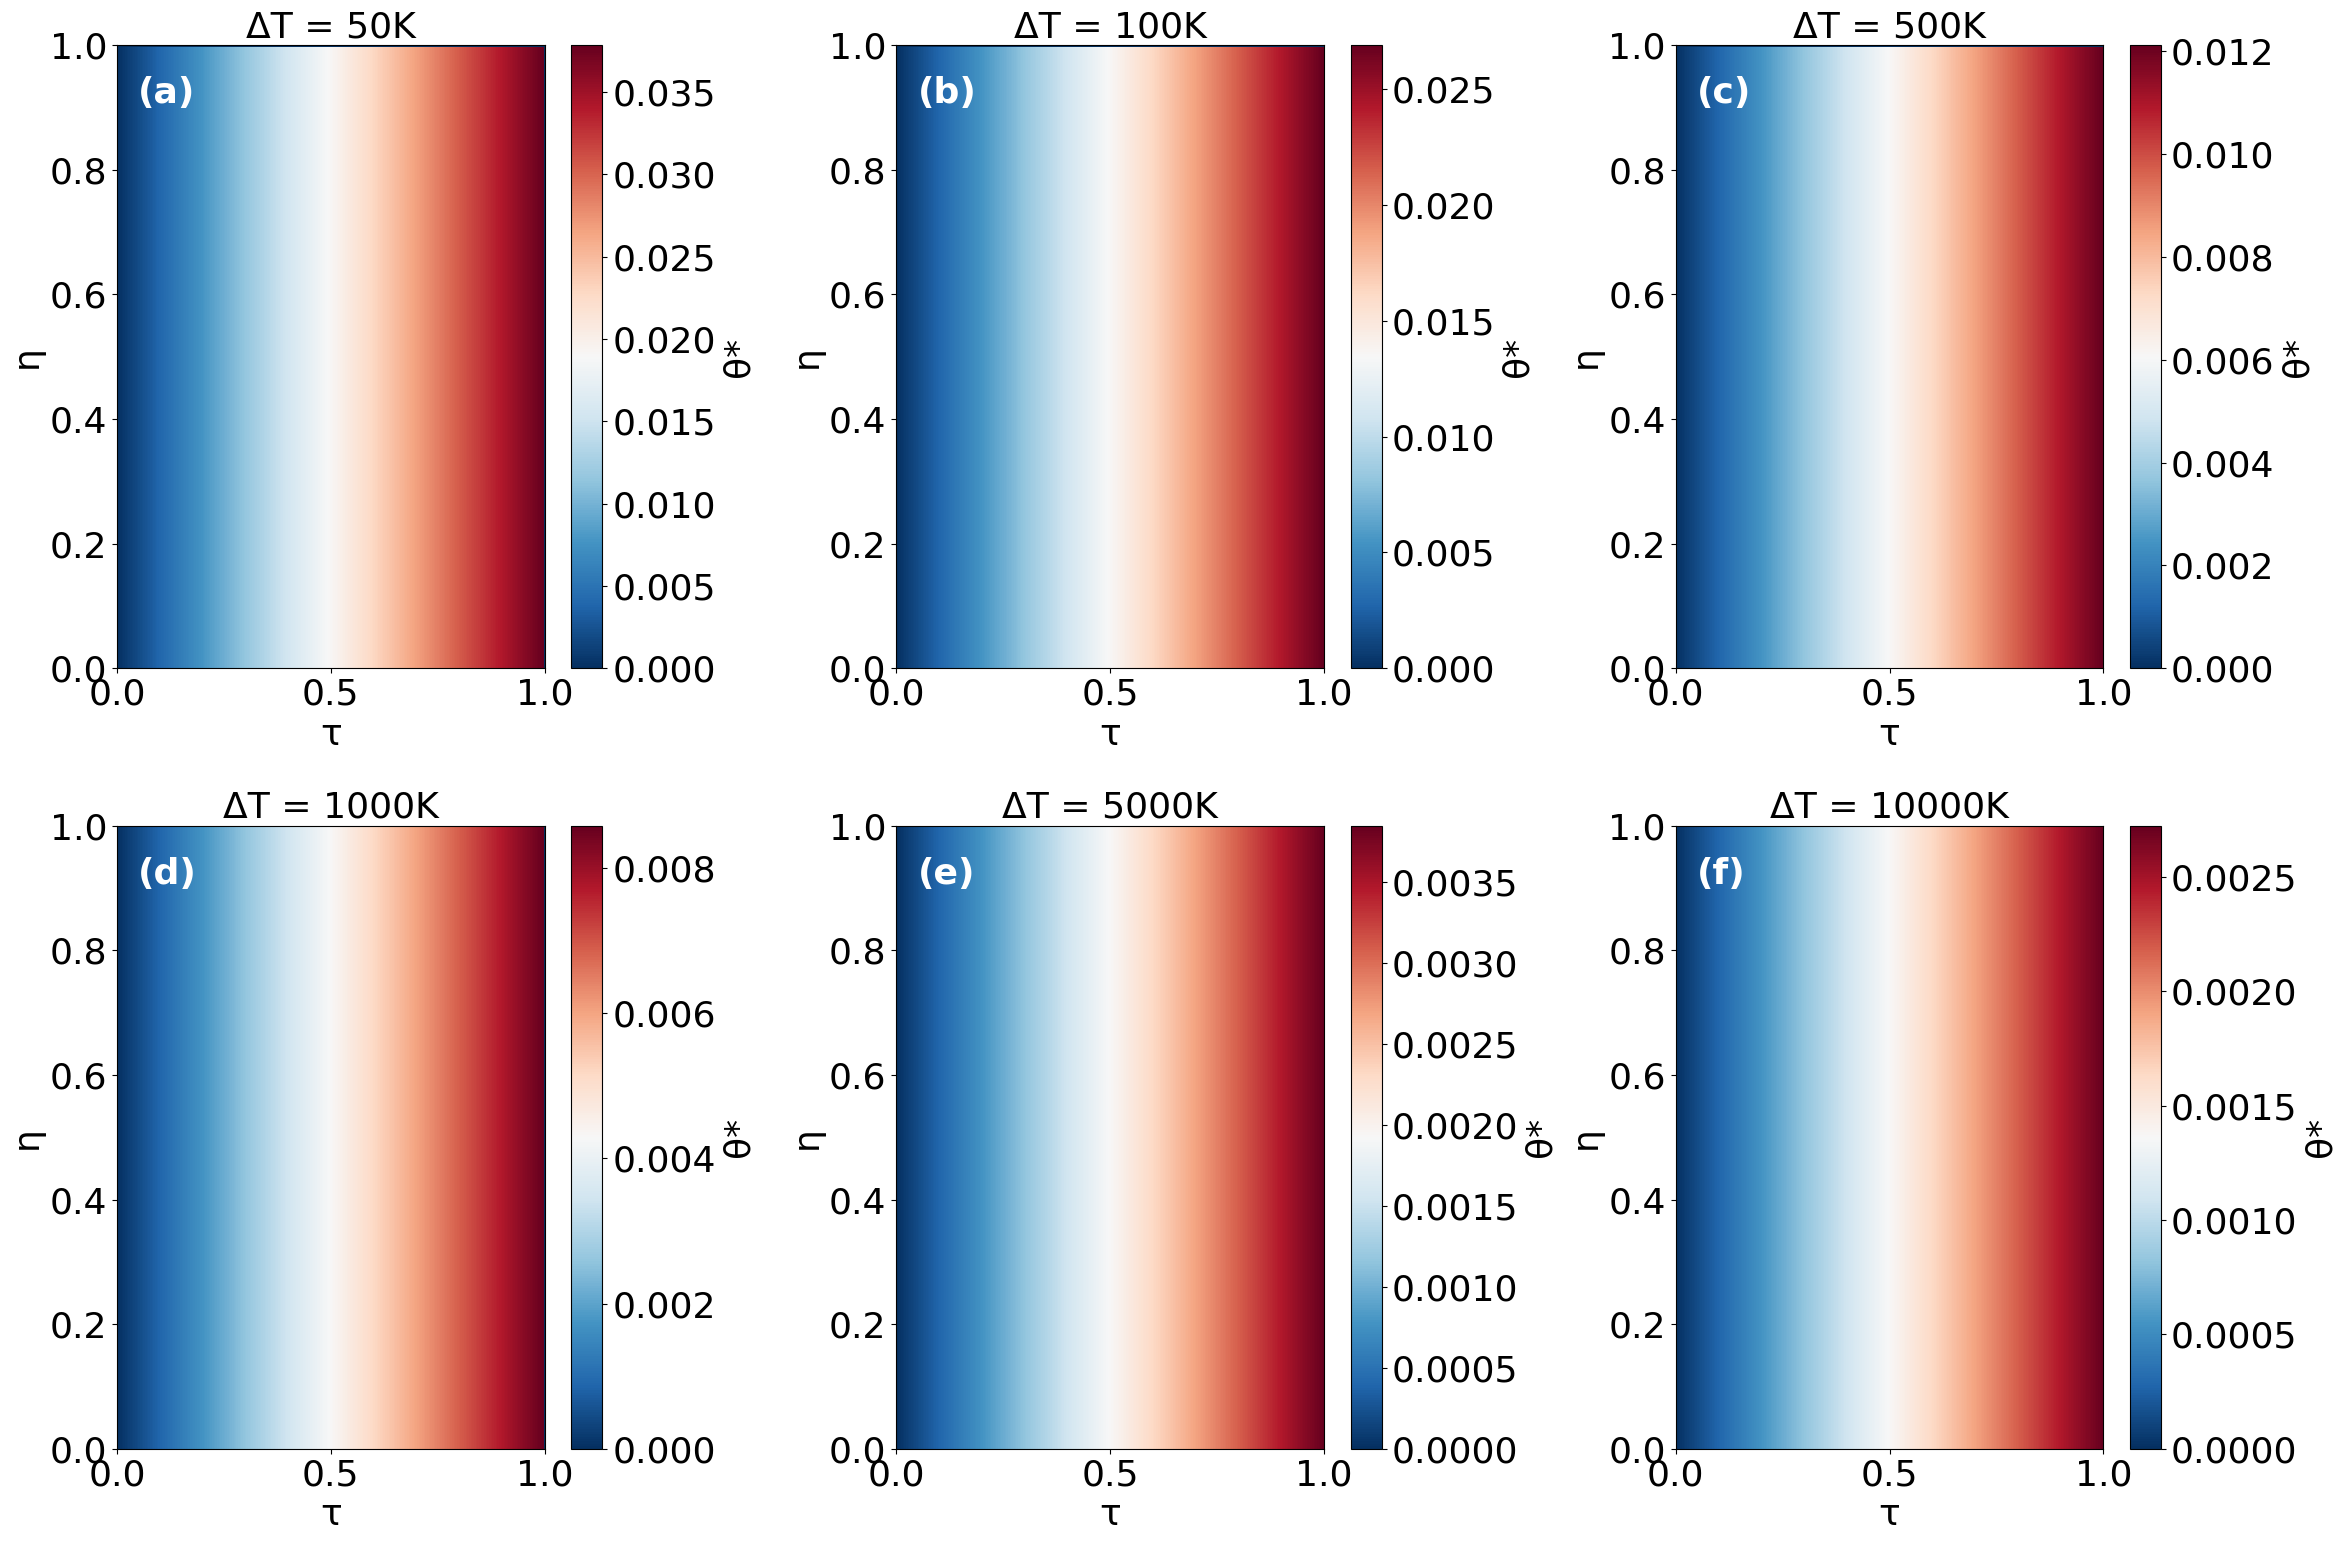

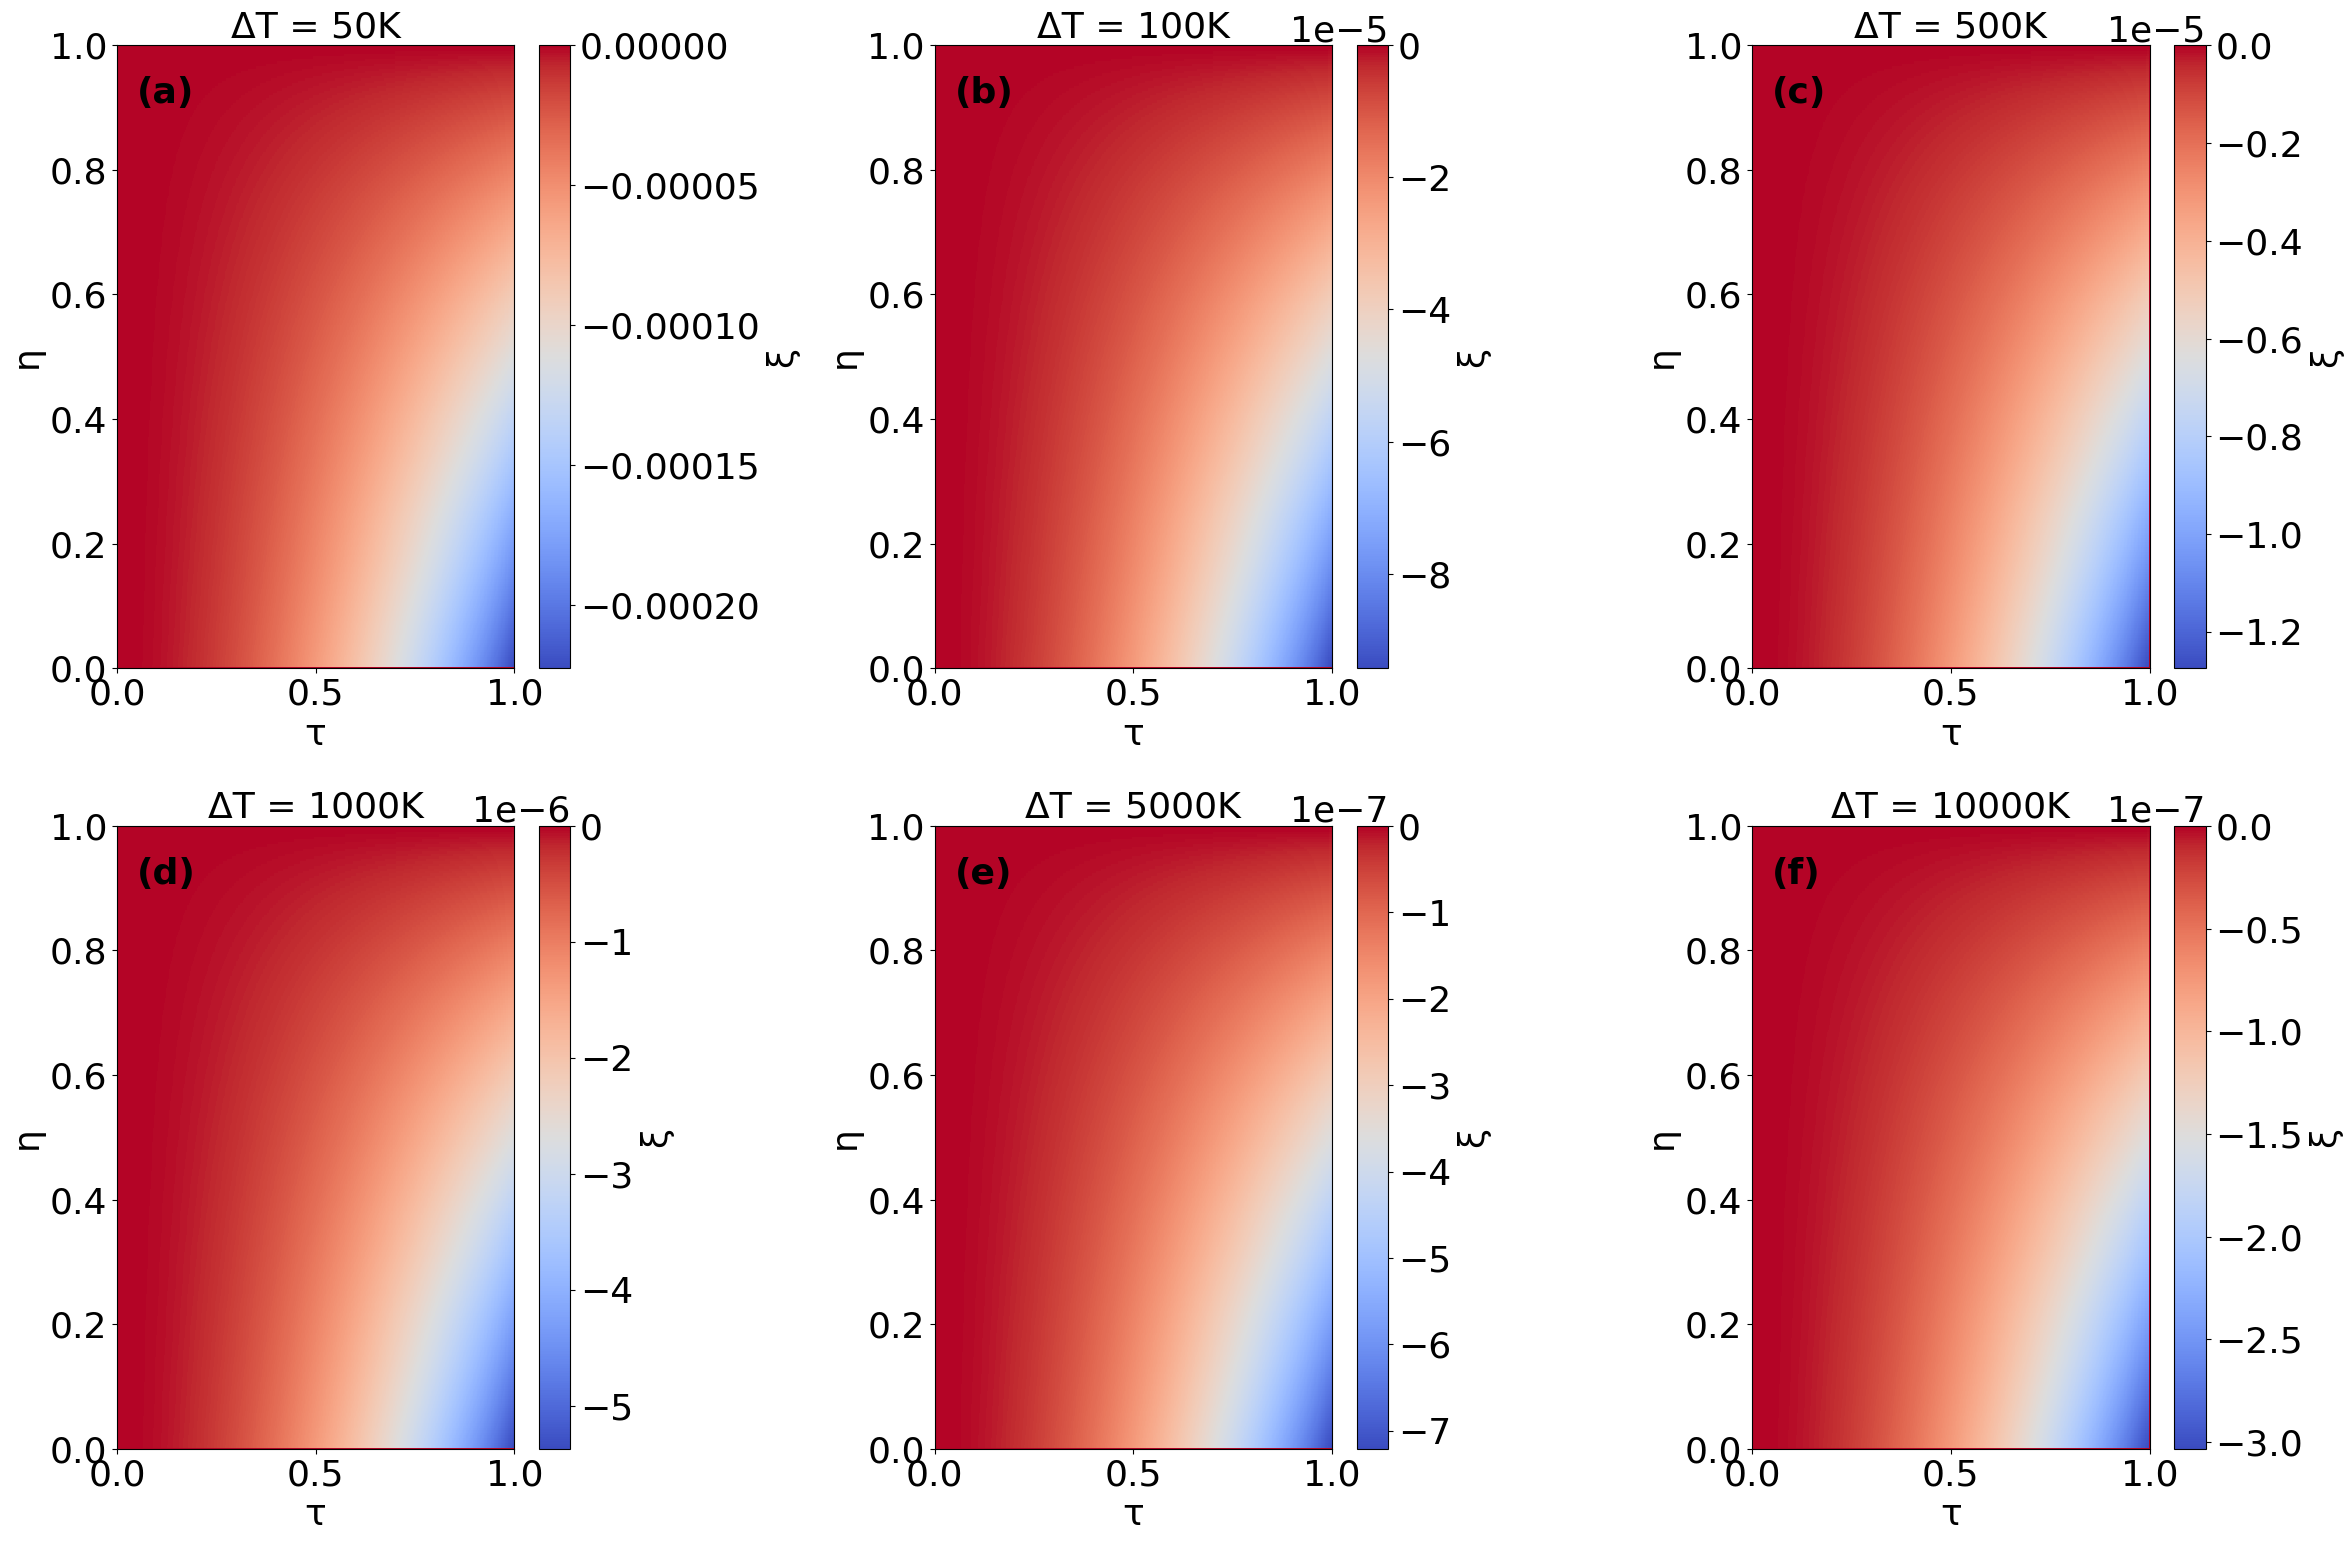

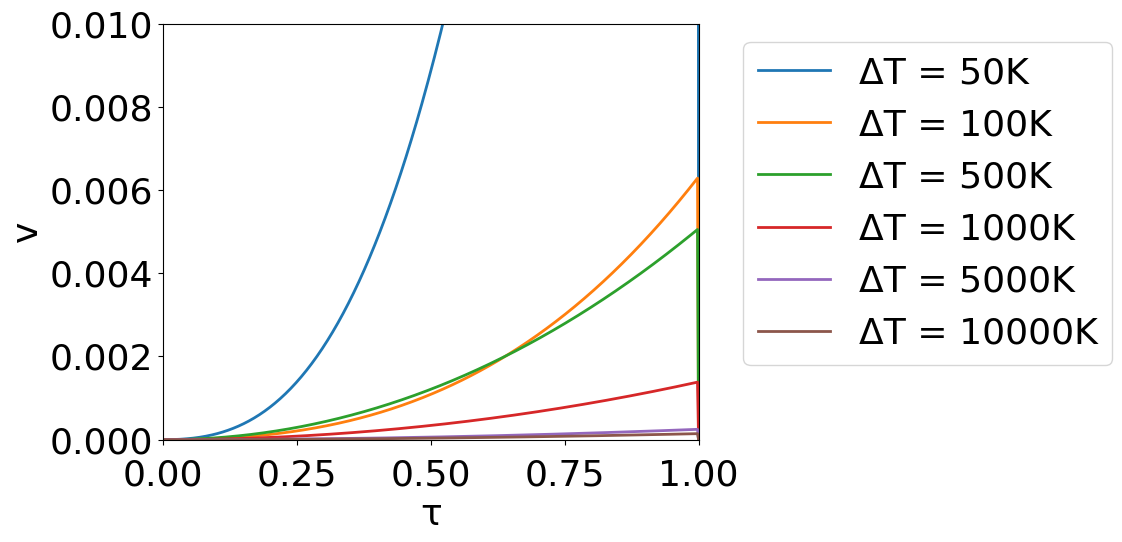

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Lista de diferencias de temperatura
delta_T_list = [50, 100, 500, 1000, 5000, 10000]

# Crear dos figuras con un tamaño específico
fig_theta, axs_theta = plt.subplots(2, 3, figsize=(24, 16))
fig_xi, axs_xi = plt.subplots(2, 3, figsize=(24, 16))

# Aplanar las matrices de subplots para facilitar la iteración
axs_theta = axs_theta.flatten()
axs_xi = axs_xi.flatten()

# Graficar y recopilar datos
for i, delta_T in enumerate(delta_T_list):
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, xi, eta, tau = calculo_temp_presiones(Ra, Ri, delta, v_e, LAMBDA)  
    
    # Crear el mapa de calor para theta
    im_theta = axs_theta[i].pcolormesh(tau, eta, theta_star, cmap='RdBu_r', shading='auto')
    
    # Crear el mapa de calor para xi
    im_xi = axs_xi[i].pcolormesh(tau, eta, xi, cmap='coolwarm', shading='auto')
    
    # Configurar los ejes y etiquetas para theta
    axs_theta[i].set_xlabel('τ', fontsize=26)
    axs_theta[i].set_ylabel('η', fontsize=26)
    axs_theta[i].set_title(f'ΔT = {delta_T:.0f}K', fontsize=26)
    axs_theta[i].set_xlim(0, 1)
    axs_theta[i].set_ylim(0, 1)
    axs_theta[i].tick_params(axis='both', which='major', labelsize=26)
    
    # Configurar los ejes y etiquetas para xi
    axs_xi[i].set_xlabel('τ', fontsize=26)
    axs_xi[i].set_ylabel('η', fontsize=26)
    axs_xi[i].set_title(f'ΔT = {delta_T:.0f}K', fontsize=26)
    axs_xi[i].set_xlim(0, 1)
    axs_xi[i].set_ylim(0, 1)
    axs_xi[i].tick_params(axis='both', which='major', labelsize=26)
    
    # Añadir barra de color para theta
    cbar_theta = fig_theta.colorbar(im_theta, ax=axs_theta[i])
    cbar_theta.set_label('θ*', fontsize=26)
    cbar_theta.ax.tick_params(labelsize=26)
    
    # Añadir barra de color para xi
    cbar_xi = fig_xi.colorbar(im_xi, ax=axs_xi[i])
    cbar_xi.set_label('ξ', fontsize=26)
    cbar_xi.ax.tick_params(labelsize=26)
    
    # Añadir etiqueta (a, b, c, d, e, f) en la esquina superior izquierda para theta
    axs_theta[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs_theta[i].transAxes, 
                      fontsize=26, fontweight='bold', va='top', color='white')
    
    # Añadir etiqueta (a, b, c, d, e, f) en la esquina superior izquierda para xi
    axs_xi[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs_xi[i].transAxes, 
                   fontsize=26, fontweight='bold', va='top', color='black')

# Ajustar el diseño
fig_theta.tight_layout()
fig_xi.tight_layout()

# Mostrar las gráficas
plt.show()

# Gráfica de velocidad (sin cambios)
fig, ax = plt.subplots(figsize=(12, 6))

for delta_T in delta_T_list:
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, xi, eta, tau = calculo_temp_presiones(Ra, Ri, delta, v_e, LAMBDA)  
    ax.plot(tau, v, linewidth=2, label=f'ΔT = {delta_T:.0f}K')

ax.set_xlabel('τ', fontsize=26)
ax.set_ylabel('v', fontsize=26)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.01)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='x', which='major', pad=10)

ax.legend(fontsize=26, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


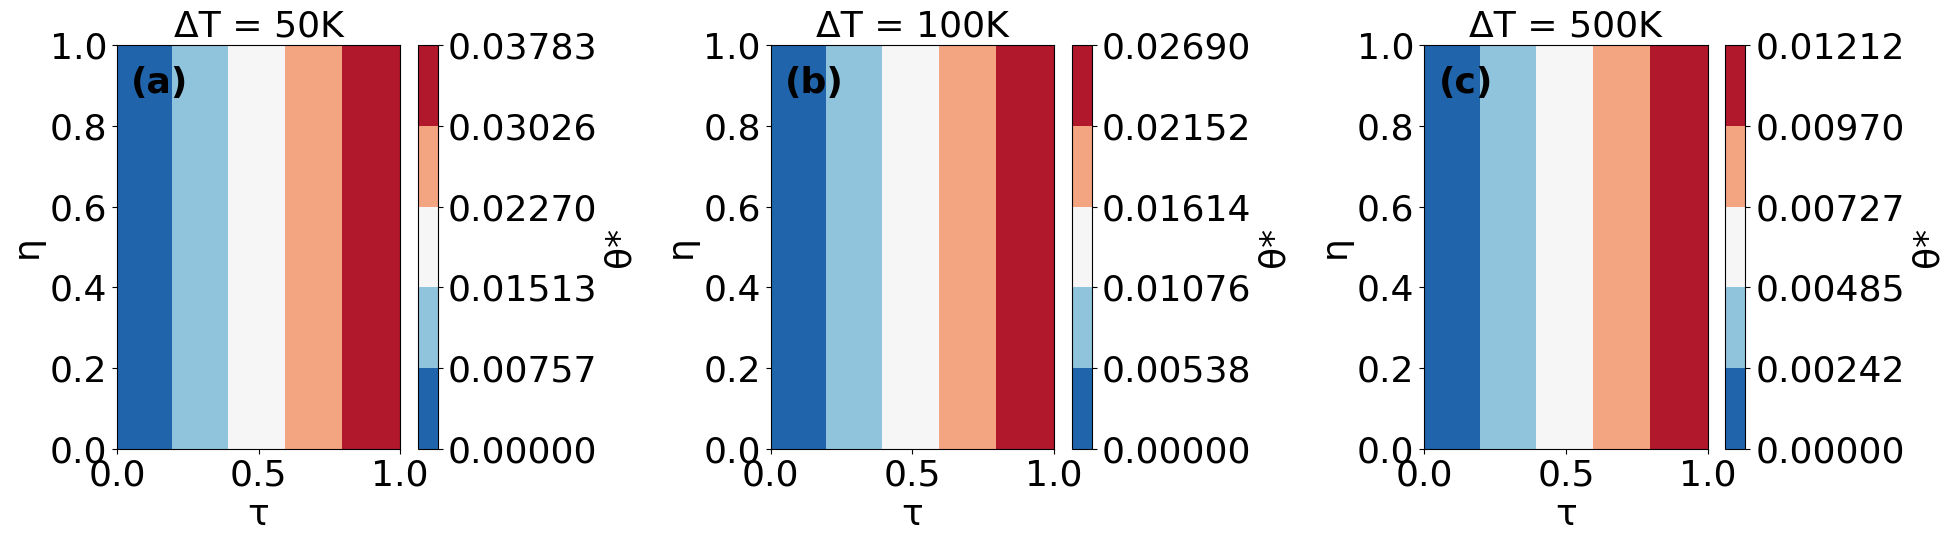

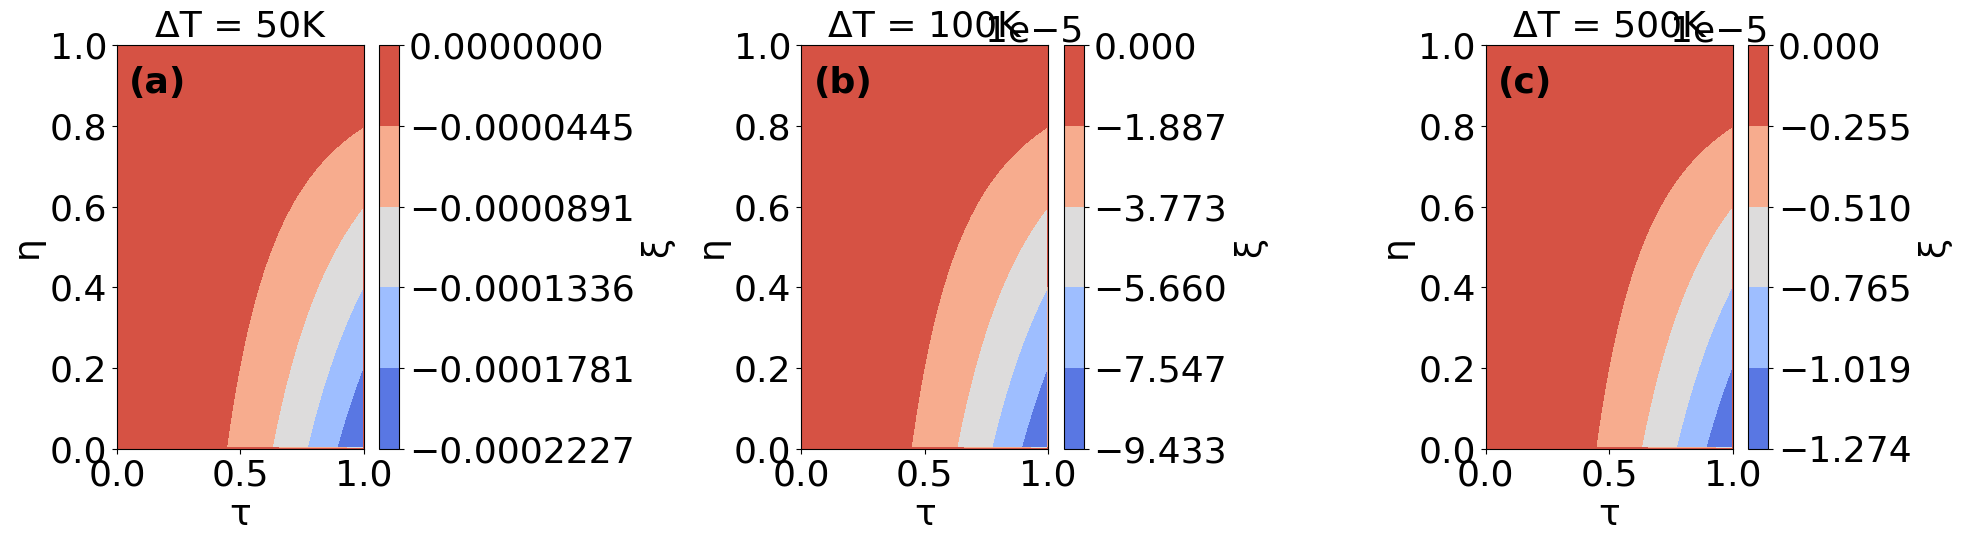

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Lista de diferencias de temperatura
delta_T_list = [50, 100, 500]

# Crear dos figuras con un tamaño específico
fig_theta, axs_theta = plt.subplots(1, 3, figsize=(20, 6))
fig_xi, axs_xi = plt.subplots(1, 3, figsize=(20, 6))

# Aplanar las matrices de subplots para facilitar la iteración
axs_theta = axs_theta.flatten()
axs_xi = axs_xi.flatten()

# Definir el número de niveles para las secciones
n_levels = 6

# Graficar y recopilar datos
for i, delta_T in enumerate(delta_T_list):
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, xi, eta, tau = calculo_temp_presiones(Ra, Ri, delta, v_e, LAMBDA)  
    
    # Crear el mapa de calor seccionado para theta
    levels_theta = np.linspace(np.min(theta_star), np.max(theta_star), n_levels)
    im_theta = axs_theta[i].contourf(tau, eta, theta_star, levels=levels_theta, cmap='RdBu_r')
    
    # Crear el mapa de calor seccionado para xi
    levels_xi = np.linspace(np.min(xi), np.max(xi), n_levels)
    im_xi = axs_xi[i].contourf(tau, eta, xi, levels=levels_xi, cmap='coolwarm')
    
    # Configurar los ejes y etiquetas para theta
    axs_theta[i].set_xlabel('τ', fontsize=26)
    axs_theta[i].set_ylabel('η', fontsize=26)
    axs_theta[i].set_title(f'ΔT = {delta_T:.0f}K', fontsize=26)
    axs_theta[i].set_xlim(0, 1)
    axs_theta[i].set_ylim(0, 1)
    axs_theta[i].tick_params(axis='both', which='major', labelsize=26)
    
    # Configurar los ejes y etiquetas para xi
    axs_xi[i].set_xlabel('τ', fontsize=26)
    axs_xi[i].set_ylabel('η', fontsize=26)
    axs_xi[i].set_title(f'ΔT = {delta_T:.0f}K', fontsize=26)
    axs_xi[i].set_xlim(0, 1)
    axs_xi[i].set_ylim(0, 1)
    axs_xi[i].tick_params(axis='both', which='major', labelsize=26)
    
    # Añadir barra de color para theta
    cbar_theta = fig_theta.colorbar(im_theta, ax=axs_theta[i], ticks=levels_theta)
    cbar_theta.set_label('θ*', fontsize=26)
    cbar_theta.ax.tick_params(labelsize=26)
    
    # Añadir barra de color para xi
    cbar_xi = fig_xi.colorbar(im_xi, ax=axs_xi[i], ticks=levels_xi)
    cbar_xi.set_label('ξ', fontsize=26)
    cbar_xi.ax.tick_params(labelsize=26)
    
    # Añadir etiqueta (a, b, c, d, e, f) en la esquina superior izquierda para theta
    axs_theta[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs_theta[i].transAxes, 
                      fontsize=26, fontweight='bold', va='top', color='black')
    
    # Añadir etiqueta (a, b, c, d, e, f) en la esquina superior izquierda para xi
    axs_xi[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs_xi[i].transAxes, 
                   fontsize=26, fontweight='bold', va='top', color='black')

# Ajustar el diseño
fig_theta.tight_layout()
fig_xi.tight_layout()

# Mostrar las gráficas
plt.show()

# La gráfica de velocidad permanece sin cambios


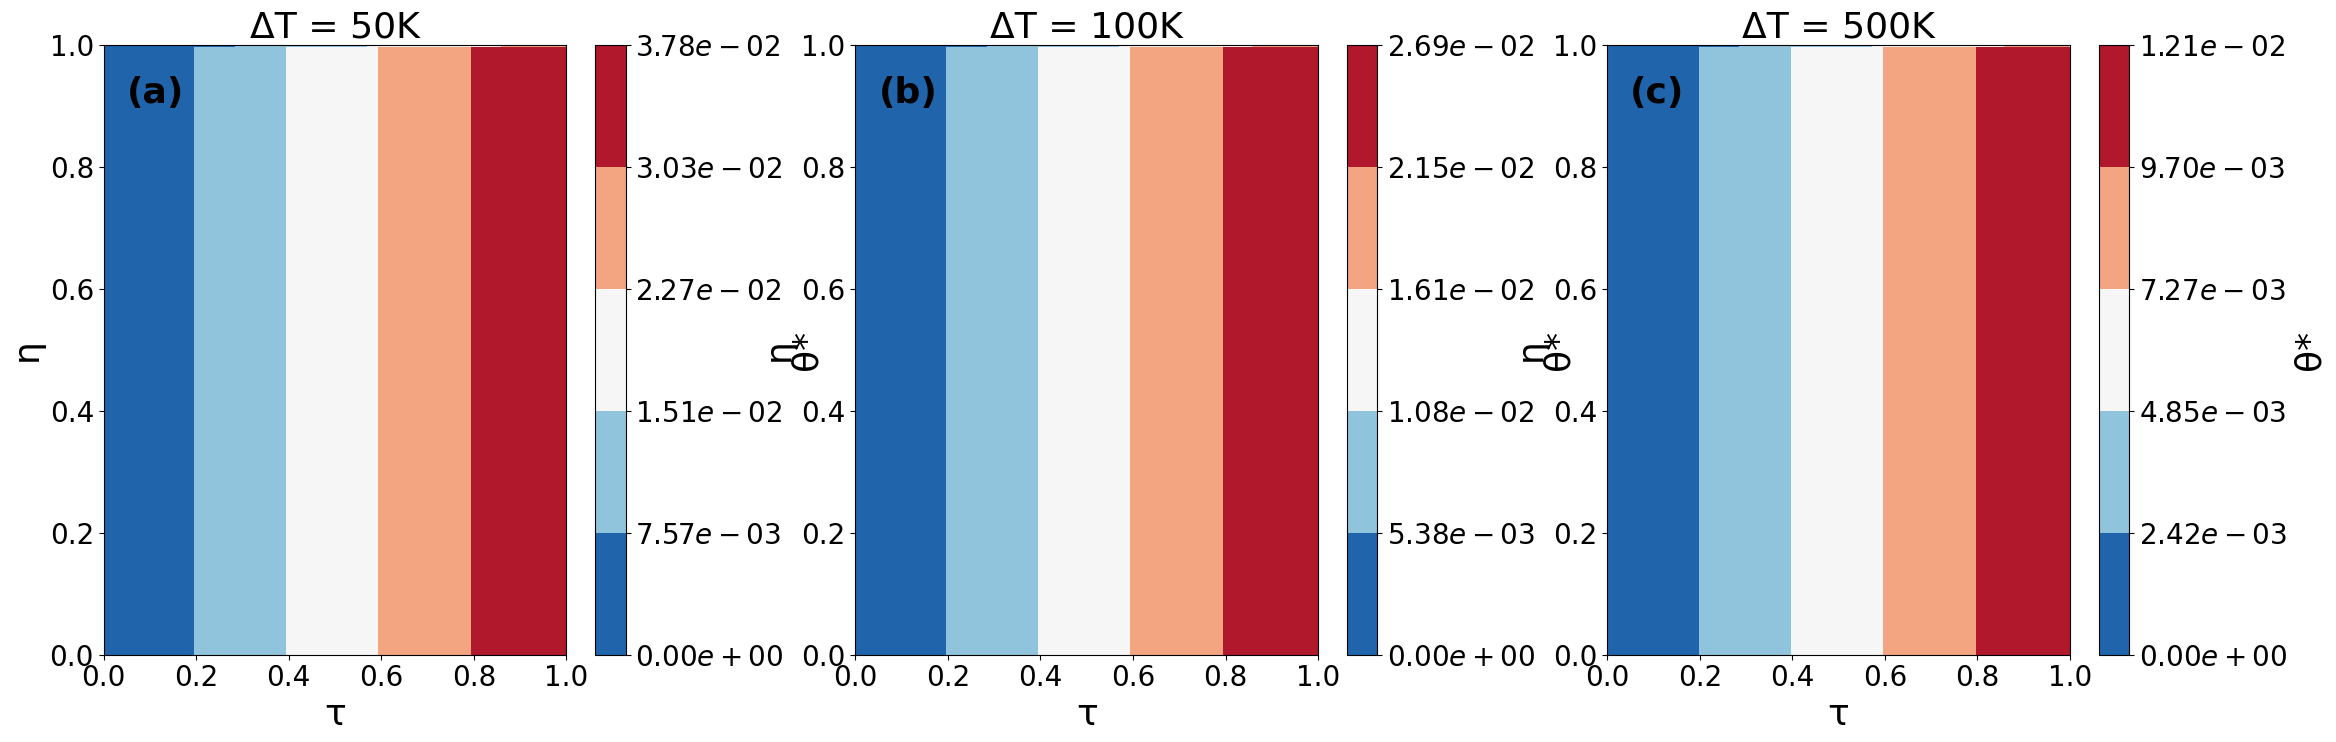

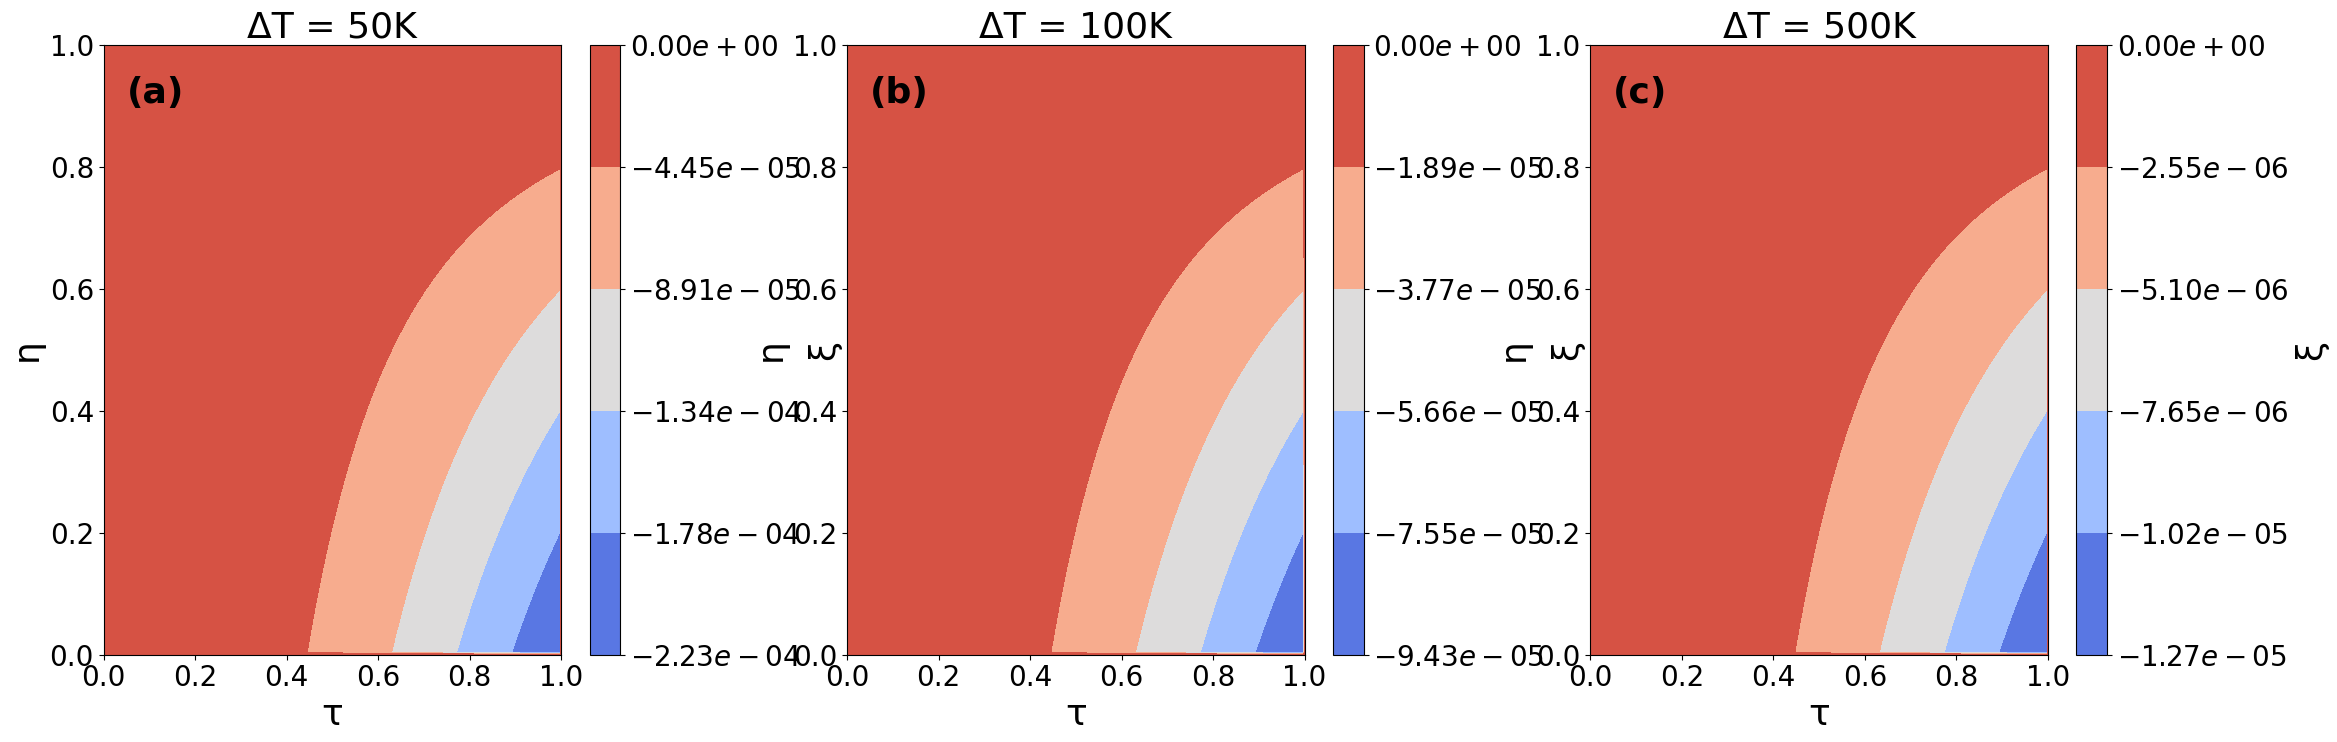

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Función para formatear los números en notación científica
def format_func(value, pos):
    return f'${value:.2e}$'

# Lista de diferencias de temperatura
delta_T_list = [50, 100, 500]

# Crear dos figuras con un tamaño específico y una mejor proporción
fig_theta, axs_theta = plt.subplots(1, 3, figsize=(24, 8))
fig_xi, axs_xi = plt.subplots(1, 3, figsize=(24, 8))

# Aplanar las matrices de subplots para facilitar la iteración
axs_theta = axs_theta.flatten()
axs_xi = axs_xi.flatten()

# Definir el número de niveles para las secciones
n_levels = 6

# Graficar y recopilar datos
for i, delta_T in enumerate(delta_T_list):
    h, phi, Ri, Ra, LAMBDA, delta = parametros(D, L, delta_T)
    v_e = newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100)
    v, theta_star, xi, eta, tau = calculo_temp_presiones(Ra, Ri, delta, v_e, LAMBDA)  
    
    # Crear el mapa de calor seccionado para theta
    levels_theta = np.linspace(np.min(theta_star), np.max(theta_star), n_levels)
    im_theta = axs_theta[i].contourf(tau, eta, theta_star, levels=levels_theta, cmap='RdBu_r')
    
    # Crear el mapa de calor seccionado para xi
    levels_xi = np.linspace(np.min(xi), np.max(xi), n_levels)
    im_xi = axs_xi[i].contourf(tau, eta, xi, levels=levels_xi, cmap='coolwarm')
    
    # Configurar los ejes y etiquetas para theta
    axs_theta[i].set_xlabel('τ', fontsize=26)
    axs_theta[i].set_ylabel('η', fontsize=26)
    axs_theta[i].set_title(f'ΔT = {delta_T:.0f}K', fontsize=26)
    axs_theta[i].set_xlim(0, 1)
    axs_theta[i].set_ylim(0, 1)
    axs_theta[i].tick_params(axis='both', which='major', labelsize=20)
    
    # Configurar los ejes y etiquetas para xi
    axs_xi[i].set_xlabel('τ', fontsize=26)
    axs_xi[i].set_ylabel('η', fontsize=26)
    axs_xi[i].set_title(f'ΔT = {delta_T:.0f}K', fontsize=26)
    axs_xi[i].set_xlim(0, 1)
    axs_xi[i].set_ylim(0, 1)
    axs_xi[i].tick_params(axis='both', which='major', labelsize=20)
    
    # Añadir barra de color para theta con formato personalizado
    cbar_theta = fig_theta.colorbar(im_theta, ax=axs_theta[i], ticks=levels_theta, format=FuncFormatter(format_func))
    cbar_theta.set_label('θ*', fontsize=26)
    cbar_theta.ax.tick_params(labelsize=20)
    
    # Añadir barra de color para xi con formato personalizado
    cbar_xi = fig_xi.colorbar(im_xi, ax=axs_xi[i], ticks=levels_xi, format=FuncFormatter(format_func))
    cbar_xi.set_label('ξ', fontsize=26)
    cbar_xi.ax.tick_params(labelsize=20)
    
    # Añadir etiqueta (a, b, c) en la esquina superior izquierda para theta
    axs_theta[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs_theta[i].transAxes, 
                      fontsize=26, fontweight='bold', va='top', color='black')
    
    # Añadir etiqueta (a, b, c) en la esquina superior izquierda para xi
    axs_xi[i].text(0.05, 0.95, f'({chr(97 + i)})', transform=axs_xi[i].transAxes, 
                   fontsize=26, fontweight='bold', va='top', color='black')

# Ajustar el diseño
fig_theta.tight_layout()
fig_xi.tight_layout()

# Añadir espacio entre subplots
fig_theta.subplots_adjust(wspace=0.3)
fig_xi.subplots_adjust(wspace=0.3)

# Mostrar las gráficas
plt.show()
